In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на обезличенном датасете i2b2 2014 без учёта регистра

### Этап 3: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [7]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
anonymization = ReferenceBookAnonymization(anon_config['path_to_first_male_names'],
                                           anon_config['path_to_first_femail_names'],
                                           anon_config['path_to_last_names'],
                                           anon_config['path_to_full_addresses'],
                                           anon_config['path_to_countries'],
                                           anon_config['path_to_states'],
                                           anon_config['path_to_cities'],
                                           anon_config['path_to_streets'],
                                           anon_config['path_to_organizations'],
                                           anon_config['path_to_hospitals'],
                                           anon_config['path_to_professions'],
                                           other_label=i2b2_2006_data_config['other_label'])

In [8]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"], 
                               anonymization=anonymization,
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9967068433761597
     test_precision         0.9967068433761597
       test_recall           0.969675600528717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.969675600528717,
  'test_precision': 0.9967068433761597,
  'test_f1': 0.9967068433761597}]

              precision    recall  f1-score   support

        NAME     0.9551    0.9925    0.9734      9067
  PROFESSION     0.9127    0.9324    0.9224       695
    LOCATION     0.9477    0.9075    0.9272     10242
         AGE     0.9652    0.9848    0.9749      1184
        DATE     0.9923    0.9871    0.9897     35814
          ID     0.9665    0.9175    0.9413      4337
     CONTACT     0.8996    0.9858    0.9407      2471

   micro avg     0.9729    0.9697    0.9713     63810
   macro avg     0.9484    0.9582    0.9528     63810
weighted avg     0.9731    0.9697    0.9711     63810


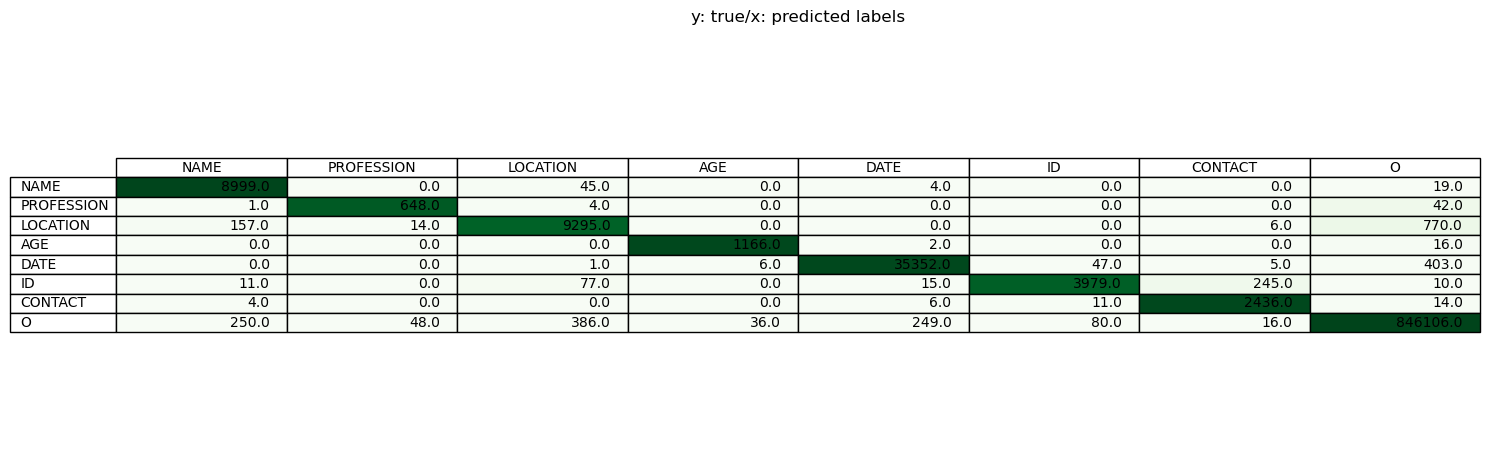

Wrongly predicted examples:
_____ Record 378-04:-34 _____
| Sentence:    | and | expressively | impaired | following | rupture | of | a | cerebral | aneurysm | 06   | /    | may  | /    | 1970 | ; | she | was | required | sub | - | occipital | craniotomy | , | clot | evacuation | , | and | placement | for | a | vp | shunt | . | she | was | transferred | to | howard   | county   | general  | hospital | 06   | -    | 07   | -    | 2087 | , | and | was | d | / | c | ' | d | 1937 | may  | 14   | . | discharge | summary | indicates | that | her | baseline | at | that | time | included | being | able | to | follow | 1 | step | commands | part | of | the | time | and | some | attempts | at | communication |
| True labels: | O   | O            | O        | O         | O       | O  | O | O        | O        | DATE | DATE | DATE | DATE | DATE | O | O   | O   | O        | O   | O | O         | O          | O | O    | O          | O | O   | O         | O   | O | O  | O     | O | O   | O   | O     

In [11]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [12]:
faults = stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 137-01:-17 _____
| Sentence:    | record | date | : | jan  | -    | 25   | -    | 1978 | bryn     | mawr     | hospital | physician | group | devereux | court    | terry | jeanette | marsberg | , | iowa     | 15605    | 3140364589763833 | (       | 609     | )       | 601     | -       | 7431    | 2064 | mar  | 26   | history | of | present | illness | : | this | 50  | - | year | - | old | white | male | comes | to | the | office | for | followup | regarding | his | recent | chest | pain | . | chest | pain | . | the | patient | was | in | his | usual | state | of | compensated | health | , | but | approximately | one | month | ago | after | clearing | significance | note | from |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | LOCATION | LOCATION | O         | O     | LOCATION | LOCATION | NAME  | NAME     | LOCATION | O | LOCATION | LOCATION | ID               | CONTACT | CONTACT | CONTACT | CONTACT | CONTACT 

**Вывод:**  
В целом все метки предсказываются с точностью, близко к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 4: Обучение модели на анонимизированных данных

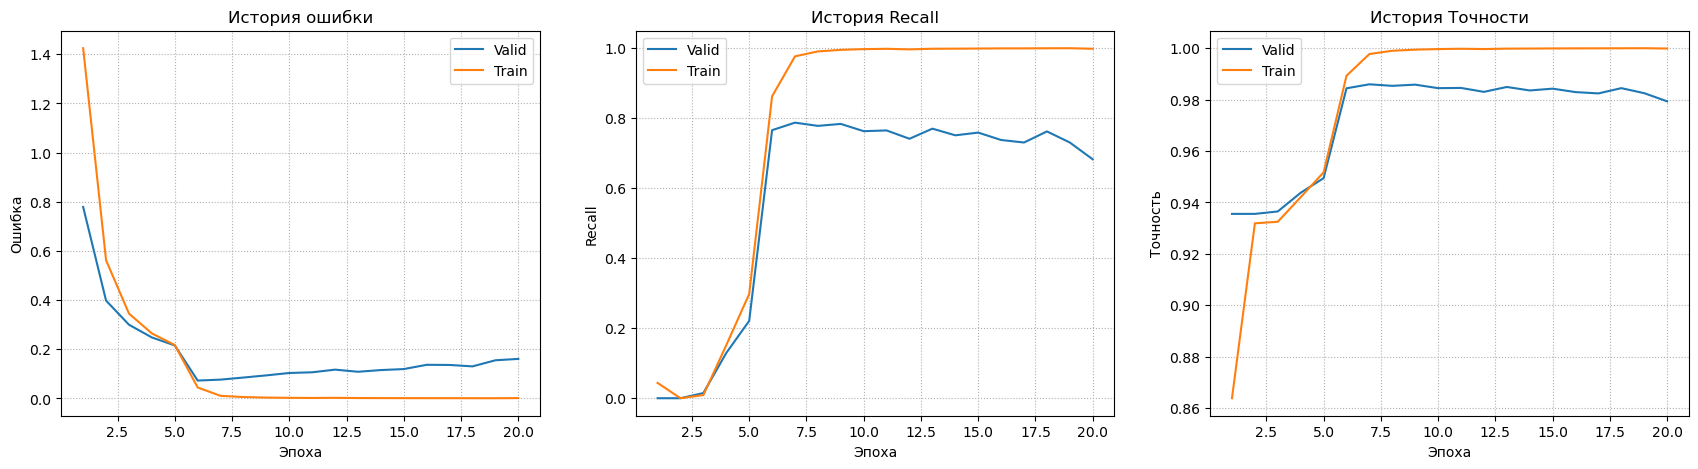

In [13]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(4)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [14]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [15]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(4)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [16]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9859273433685303
     test_precision         0.9859273433685303
       test_recall          0.7871394157409668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.7871394157409668,
  'test_precision': 0.9859273433685303,
  'test_f1': 0.9859273433685303}]

              precision    recall  f1-score   support

        NAME     0.9912    0.6966    0.8182     11741
  PROFESSION     0.9713    0.7210    0.8276       656
    LOCATION     0.8498    0.7168    0.7776      6211
         AGE     0.9458    0.8723    0.9076      1300
        DATE     0.9937    0.8519    0.9173     32754
          ID     0.8893    0.6483    0.7499      4510
     CONTACT     0.6407    0.7386    0.6862      1270

   micro avg     0.9582    0.7871    0.8643     58442
   macro avg     0.8974    0.7494    0.8121     58442
weighted avg     0.9608    0.7871    0.8634     58442


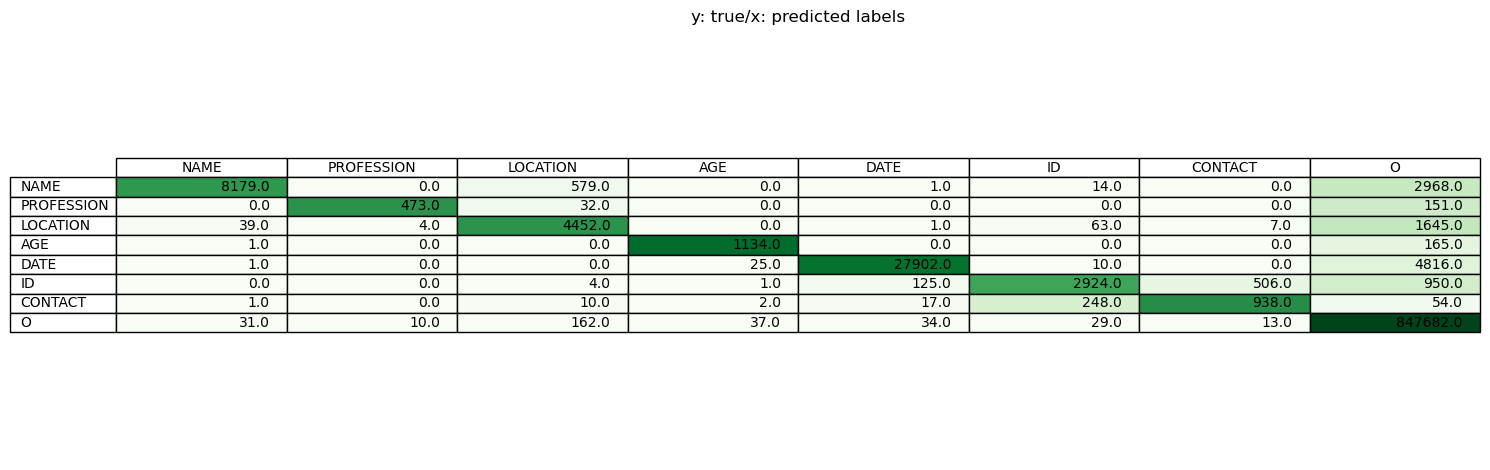

Wrongly predicted examples:
_____ Record 311-04:-2 _____
| Sentence:    | . | primary | diagnosis | : | atrial | flutter | with | rapid | ventricular | response | . | secondary | diagnosis | : | left | arm | pain | . | critical | care | time | : | 35 | minutes | . | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | yeager | ,    | harold | m | . | d | . | d | : | 11   | /    | 05   | /    | 89   | t | : | 11   | /    | 05   | /    | 89   | dictated | by | : | yeager | ,    | harold | escription | document | : | 0  | -       | 6602107 |
| True labels: | O | O       | O         | O | O      | O       | O    | O     | O           | O        | O | O         | O         | O | O    | O   | O    | O | O        | O    | O    | O | O  | O       | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | NAME   | NAME | NAME   | O | O | O | O | O | O | DATE | DA

In [17]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

In [18]:
faults = stats.get_specific_failed_predictions('NAME')

Wrongly predicted examples:
_____ Record 343-01:-10 _____
| Sentence:    | record | date | : | 2094 | -    | 10   | -    | 26   | saint    | john     | valley   | health   | center   | 157      | peterborough | place    | kim  | jr   | ,    | douglas | sulphur  | , | ar       | 26822    | 20163512 | (       | 426     | )       | 819     | -       | 5183    | 10   | /    | 26   | /    | 94   | chief | complaint | : | followup | of | atrial | fibrillation | and | recent | lab | results | . | history | of | present | illness | : | a | 54  | year | old | male | with | history | of | paroxysmal | atrial | fibrillation | , | borderline | diabetes | , | and | borderline | hypertension | who | presents | back | to | clinic | for |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION | LOCATION     | LOCATION | NAME | NAME | NAME | NAME    | LOCATION | O | LOCATION | LOCATION | ID       | CONTACT | CONTACT | CONT

In [19]:
faults = stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 263-01:-1 _____
| Sentence:    | /    | 1620 | virgil | l    | .    | ivery | , | m | . | d | . | vi65 | d | : | 02   | /    | 28   | /    | 79   | t | : | 02   | /    | 28   | /    | 79   | dictated | by | : | virgil | l    | .    | ivery | , | m | . | d | . | vi65 | * | * | * | * | * | * | * | * | not | reviewed | by | attending | physician | * | * | * | * | * | * | * |
| True labels: | ID   | ID   | NAME   | NAME | NAME | NAME  | O | O | O | O | O | NAME | O | O | DATE | DATE | DATE | DATE | DATE | O | O | DATE | DATE | DATE | DATE | DATE | O        | O  | O | NAME   | NAME | NAME | NAME  | O | O | O | O | O | NAME | O | O | O | O | O | O | O | O | O   | O        | O  | O         | O         | O | O | O | O | O | O | O |
| Pred labels: | DATE | DATE | NAME   | NAME | O    | NAME  | O | O | O | O | O | O    | O | O | DATE | DATE | DATE | DATE | DATE | O | O | DATE | DATE | DATE | DATE | DATE | O        | O  | O | NAME   | NAME | O    | NAME  |